Преподаватель: Вячеслав Мурашкин
Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [108]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Загружаем исходные данные

In [109]:
train = np.loadtxt('./digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./digit/test.csv', delimiter=',', skiprows=1)

In [110]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
print(train.shape)

(42000, 785)


In [111]:
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [112]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

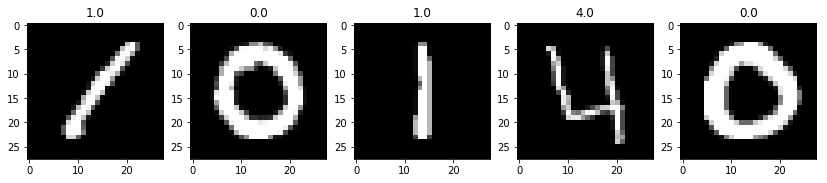

In [113]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Получаем дескрипторы HOG

In [114]:
# Процедура получения HOG дескриптора.
def get_hog(img):
    
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    cell_size = (14, 14)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    _nbins = 33  # number of orientation bins

    _winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0])

    _blockSize=(block_size[1] * cell_size[1], block_size[0] * cell_size[0])
    _blockStride=(cell_size[1], cell_size[0])
    _cellSize=(cell_size[1], cell_size[0])
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize, _blockSize, _blockStride, _cellSize, _nbins,\
        derivAperture, winSigma, histogramNormType, L2HysThreshold,gammaCorrection,nlevels)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
    hog_feats = hog.compute(img)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], _nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
    return hog_feats



In [115]:
%%time
hogs_train = []
#train_img[0].shape
for i, img in enumerate(train_img, 1):
    img = img.astype(np.uint8)
    hog = get_hog(img)
    hogs_train.append(hog)
hogs_train = np.array(hogs_train)
pdlabel_Y = pd.DataFrame(train_label.astype(np.uint8))
Y_train = pd.get_dummies(pdlabel_Y[pdlabel_Y.columns[0]])

hogs_val = []
for i, img in enumerate(test_img, 1):
    img = img.astype(np.uint8)
    hog = get_hog(img)
    hogs_val.append(hog)
hogs_val = np.array(hogs_val)

CPU times: user 3.15 s, sys: 16 ms, total: 3.17 s
Wall time: 3.17 s


In [116]:
# Узнаём текущую размерность
print(hogs_train.shape)
print(hogs_val.shape)

(42000, 1, 1, 2, 2, 33)
(28000, 1, 1, 2, 2, 33)


In [117]:
# Меняем размерность на пригодную для обучения
hogs_train = pd.DataFrame(hogs_train.reshape(42000,33*4))
hogs_val = pd.DataFrame(hogs_val.reshape(28000,33*4))
# Снова проверяем размерность
print(hogs_train.shape)
print(hogs_val.shape)
print(Y_train.shape)

(42000, 132)
(28000, 132)
(42000, 10)


In [118]:
# Визуальный осмотр данных
print(hogs_train[0:1])
print(Y_train.head())

       0         1         2         3         4         5         6    \
0  0.04658  0.092005  0.069926  0.033707  0.030962  0.053908  0.245797   

        7         8         9      ...          122       123  124  125  126  \
0  0.263762  0.263762  0.087449    ...     0.000252  0.000266  0.0  0.0  0.0   

        127       128       129      130       131  
0  0.000097  0.000155  0.008006  0.00794  0.024549  

[1 rows x 132 columns]
   0  1  2  3  4  5  6  7  8  9
0  0  1  0  0  0  0  0  0  0  0
1  1  0  0  0  0  0  0  0  0  0
2  0  1  0  0  0  0  0  0  0  0
3  0  0  0  0  1  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0


# Проверяем качество на классификаторе

In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(hogs_train, pdlabel_Y, test_size=0.5, random_state=42)

In [120]:
%%time
model = RandomForestClassifier(max_depth=15, random_state=1,  n_estimators=50)
model.fit(X_train, Y_train)
pred_test = model.predict(X_test)

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


CPU times: user 10.6 s, sys: 3.96 ms, total: 10.6 s
Wall time: 10.6 s


In [121]:
#print(np.mean(cuscore))
#print(np.min(cuscore))

In [122]:
#pred_val = model.predict(X_val)

In [123]:
print('Accuracy: %s' % accuracy_score(Y_test, pred_test))

Accuracy: 0.8025714285714286


In [124]:
print(classification_report(Y_test, pred_test))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2052
           1       0.98      0.96      0.97      2330
           2       0.78      0.70      0.74      2096
           3       0.69      0.76      0.72      2222
           4       0.75      0.76      0.76      2053
           5       0.73      0.71      0.72      1833
           6       0.86      0.87      0.86      2079
           7       0.93      0.85      0.89      2191
           8       0.74      0.80      0.77      2062
           9       0.75      0.80      0.78      2082

   micro avg       0.80      0.80      0.80     21000
   macro avg       0.80      0.80      0.80     21000
weighted avg       0.81      0.80      0.80     21000



In [125]:
print(confusion_matrix(Y_test, pred_test))

[[1622   31   49   64   14   95   71    9   39   58]
 [  24 2245    1    1   35    0    3   17    1    3]
 [  52    3 1463  215  158   52   40   44   46   23]
 [  17    0  115 1678   18  111    5    8  179   91]
 [  53    4  116   29 1556    7   68   18   37  165]
 [  11    1   28  222   29 1308   43    6  135   50]
 [  82    1   22   11   37   69 1802    1   50    4]
 [   9    8   47    8  125   21    1 1864   11   97]
 [  44    1   14  117   22  104   52    5 1646   57]
 [  80    1   18   95   67   32   12   36   71 1670]]


# Качество устраивает поэтому обучаем модель на всей выборки и делаем предсказания на валидационной.

In [126]:
model2 = RandomForestClassifier(max_depth=15, random_state=1,  n_estimators=50)
model2.fit(hogs_train, pdlabel_Y)
pred_val = model2.predict(hogs_val)

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


## Визуализируем предсказания

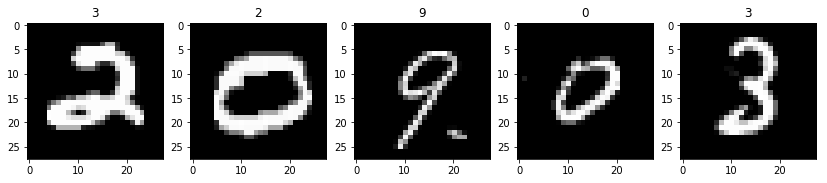

In [127]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_val[i - 1]);

## Готовим файл для отправки

In [128]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_val, 1):
        dst.write('%s,%s\n' % (i, p))

In [129]:
!head submit.txt

ImageId,Label
1,3
2,2
3,9
4,0
5,3
6,2
7,0
8,3
9,0


In [130]:
# Your submission scored 0.8025714285714286